I'll use LSH for Content based collaborative filtering, so install sparselsh if you don't have it

In [1]:
pip install sparselsh

Note: you may need to restart the kernel to use updated packages.


In [1]:
import math
import random
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
from scipy import sparse
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
from sparselsh import LSH
from collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.sparse import vstack

### Load the data

In [2]:
df_book_info = pd.read_csv('../data/amazon_v2/books_meta.csv') 
df_book_info.head()

,item_id,title,price,categories
0,1,Parker & Knight,0.0,"['Books', 'Mystery, Thriller & Suspense', 'Thr..."
1,2,Need You Now - A Story of Hope,13.97,[]
2,3,Jealousy,0.0,"['Books', 'Mystery, Thriller & Suspense', 'Thr..."
3,4,Meat Eater: Adventures from the Life of an Ame...,49.0,"['Books', 'Cookbooks, Food & Wine', 'Cooking b..."
4,5,The Last Valley: Dien Bien Phu and the French ...,37.43,"['Books', 'History', 'Military']"


In [3]:
df_book_rating = pd.read_csv('../data/amazon_v2/books_ratings_training.csv') 
df_book_rating_test = pd.read_csv('../data/amazon_v2/books_ratings_test.csv')
df_book_rating.head()

,user_id,item_id,rating,timestamp
0,3361,53296,5.0,1543536132144
1,4471,1424,5.0,1543536168823
2,342,50326,5.0,1543536419204
3,10576,1953,5.0,1543536938535
4,7282,51145,5.0,1543537322164


### Superficial EDA

In [4]:
# Are there duplicates?
rate_books = len(df_book_rating[df_book_rating.duplicated()])
book_info = len(df_book_info[df_book_info.duplicated()])
print(f'Number of duplicates in the books meta data {book_info} and in the ratings {rate_books}')

Number of duplicates in the books meta data 0 and in the ratings 0


In [5]:
# Nan values?
nan_values = df_book_info.isna().sum()
nan_values

item_id          0
title            0
price         7647
categories       0
dtype: int64

Although apparently there seems to be non NaN values (except in the price column which are not really important), since the categories column would be really relevant later on, let's check that all rows are populated:

In [6]:
df_book_info[df_book_info['categories']=='[]']

,item_id,title,price,categories
1,2,Need You Now - A Story of Hope,13.97,[]
46,47,Irrelevant: Young Adult Dystopian Romance (The...,14.99,[]
200,201,Collard Valley Cooks Volume One Cookbook 2nd E...,74.83,[]
206,207,Monash's Masterpiece,25.67,[]
225,226,There Was an Old Mummy Who Swallowed a Spider,12.25,[]
...,...,...,...,...
56530,56531,W is for Wasted: A Kinsey Millhone Novel by Su...,2.99,[]
56777,56778,Star Wars: The Dark,2.67,[]
56815,56816,ENTERTAINMENT WEEKLY The Ultimate Guide to Sup...,13.21,[]
56821,56822,Sky Blue Photo Album (Holds 48 4'' x 6'' photo...,9.69,[]


Since there are no categories for these books I'll filter them out:

In [7]:
df_book_info = df_book_info[df_book_info['categories'] != '[]']

In [8]:
# Nan values?
nan_values = df_book_rating.isna().sum()
nan_values

user_id      0
item_id      0
rating       0
timestamp    0
dtype: int64

### Non personalized recommender: Top 20 popular recent books
First we'll need to convert the timestamp to date, since the timestamp's length is 12, we assume these are timestamps are in miliseconds

In [9]:
df_book_rating['date'] = pd.to_datetime(df_book_rating['timestamp'], unit='ms')

Defining recent to be within last 15 days (2 weeks), then we build the recommender:

In [10]:
def get_most_popular_recent_items(ratings, metadata, top_n=20, recent_days=15, prior_strength=10):
    # Get current date (aka last date in the df)
    current_date = ratings['date'].max()

    # Keep only books rated within the last 2 weeks
    recent_ratings = ratings[ratings['date'] >= (current_date - pd.Timedelta(days=recent_days))].copy()
    
    
    # Compute the damped mean rating for each item
    rating_agg = recent_ratings.groupby('item_id')['rating'].agg(['sum', 'count'])
    rating_counts = rating_agg['count']
    rating_sum = rating_agg['sum']
    prior = ratings['rating'].mean()
    damped_mean = (rating_sum + prior_strength * prior) / (rating_counts + prior_strength)
    recent_ratings.loc[:, 'damped_mean'] = recent_ratings['item_id'].map(damped_mean)
    
    # Get the top N most popular items
    top_items = recent_ratings.groupby('item_id')['damped_mean'].max().nlargest(top_n).reset_index()
    top_items = top_items.merge(metadata, on='item_id')
    top_items['rating_sum'] = top_items['item_id'].map(rating_sum)
    top_items['rating_count'] = top_items['item_id'].map(rating_counts)
    
    return top_items

In [11]:
top_books = get_most_popular_recent_items(df_book_rating, df_book_info)

In [12]:
top_books

,item_id,damped_mean,title,price,categories,rating_sum,rating_count
0,19873,4.731148,What the Wind Knows,0.0,"['Books', 'Literature & Fiction', 'Genre Ficti...",59.0,12
1,35178,4.726958,What I've Done (Morgan Dane Book 4),0.0,"['Books', 'Mystery, Thriller & Suspense', 'Thr...",40.0,8
2,26944,4.692828,Girls of Glass,0.0,"['Books', 'Mystery, Thriller & Suspense', 'Thr...",30.0,6
3,39896,4.692828,The Last Letter,NaN,"['Books', 'Literature & Fiction', 'Genre Ficti...",30.0,6
4,32201,4.652074,A Merciful Fate (Mercy Kilpatrick Book 5),0.0,"['Books', 'Mystery, Thriller & Suspense', 'Thr...",34.0,7
5,26091,4.648946,A Curse So Dark and Lonely (The Cursebreaker S...,13.0,"['Books', 'Teen & Young Adult', 'Science Ficti...",20.0,4
6,26842,4.648946,Dog Man: Brawl of the Wild: From the Creator o...,4.01,"['Books', ""Children's Books"", 'Comics & Graphi...",20.0,4
7,27432,4.648946,Zen as F*ck (Zen as F*ck Journals),13.49,"['Books', 'Stationery, Journals & Notebooks', ...",20.0,4
8,35991,4.648946,Run Away,NaN,"['Books', 'Mystery, Thriller & Suspense', 'Thr...",20.0,4
9,39546,4.648946,Construction Site on Christmas Night: (Christm...,NaN,"['Books', ""Children's Books"", 'Growing Up & Fa...",20.0,4


In [13]:
top_books_dict = top_books.set_index('item_id')['damped_mean'].to_dict()
top_books_list = list(top_books['item_id'])

In [14]:
def calculate_mrr(test_df, top_books_list):
    reciprocal_ranks = []
    
    for user_id in test_df['user_id'].unique():
        user_data = test_df[test_df['user_id'] == user_id]
        relevant_items = user_data['item_id'].tolist()
        
        for rank, item_id in enumerate(top_books_list, start=1):
            if item_id in relevant_items:
                reciprocal_ranks.append(1 / rank)
                break
        else:
            reciprocal_ranks.append(0)
    
    return np.mean(reciprocal_ranks)

def calculate_rmse(test_df, top_books_dict, top_books_list):
    squared_errors = []
    
    for user_id in test_df['user_id'].unique():
        user_data = test_df[test_df['user_id'] == user_id]
        relevant_items = user_data['item_id'].tolist()
        
        for item_id in relevant_items:
            if item_id in top_books_list:
                actual_rating = user_data[user_data['item_id'] == item_id]['rating'].values[0]
                predicted_rating = top_books_dict[item_id]
                squared_errors.append((actual_rating - predicted_rating) ** 2)
    
    return np.sqrt(np.mean(squared_errors))

non_p_mrr = calculate_mrr(df_book_rating_test, top_books_list)
non_p_rmse = calculate_rmse(df_book_rating_test, top_books_dict, top_books_list)

print(f"MRR: {non_p_mrr}")
print(f"RMSE: {non_p_rmse}")

MRR: 0.004327961570412083
RMSE: 0.753621009341959


### Content-based recommender based on $K = 50$ nearest neighbors
I'll use extracts of the steps outlined in the exercise session

#### Item profiles 
The item profiles are gonna be based on the categories of the books rated, so we need to do some preprocessing

In [15]:
df_categ = df_book_info.copy()

In [16]:
# Extract all categories from the categories list and expand the book rating
df_categ['categories'] = df_categ['categories'].str.strip('[]').str.split(', ')
df_categ = df_categ.explode('categories')
df_categ.reset_index(drop=True, inplace=True)
df_categ.head()

,item_id,title,price,categories
0,1,Parker & Knight,0.0,'Books'
1,1,Parker & Knight,0.0,'Mystery
2,1,Parker & Knight,0.0,Thriller & Suspense'
3,1,Parker & Knight,0.0,'Thrillers & Suspense'
4,3,Jealousy,0.0,'Books'


In [17]:
# Function to process the category values
def process_category(category):
    category = category.strip().replace("'", "")
    category = category.lower()
    category = category.replace(' ', '_')
    return category

df_categ['categories'] = df_categ['categories'].apply(process_category)
df_categ.head()

,item_id,title,price,categories
0,1,Parker & Knight,0.0,books
1,1,Parker & Knight,0.0,mystery
2,1,Parker & Knight,0.0,thriller_&_suspense
3,1,Parker & Knight,0.0,thrillers_&_suspense
4,3,Jealousy,0.0,books


In [18]:
# calculates the lexicon of most frequent categs.
categ_frequency_threshold = 1000 
df_lexicon = df_categ.copy()
df_lexicon['categ_count'] = df_lexicon['categories'].map(df_lexicon['categories'].value_counts())
# keep only most frequent categories
df_lexicon = df_lexicon[df_lexicon['categ_count']>categ_frequency_threshold]

# you can drop the price 
df_lexicon = df_lexicon.drop(['price'], axis=1)
df_lexicon.head()

,item_id,title,categories,categ_count
0,1,Parker & Knight,books,55749
1,1,Parker & Knight,mystery,11410
2,1,Parker & Knight,thriller_&_suspense,8907
3,1,Parker & Knight,thrillers_&_suspense,6365
4,3,Jealousy,books,55749


In [19]:
#calculate the sparse feature vector based on the TF-IDF of words in documents
#the TF-IDF vectors are saved as sparse representations into the dataframe
df_features = df_categ.groupby('item_id').agg(lambda x: ' '.join(map(str, x))).reset_index()
vectorizer = TfidfVectorizer(tokenizer=lambda x: x.split(' ')).fit(sorted(df_features['categories']))
vectorizer.vocabulary_
df_features['feature_vector'] = df_features['categories'].apply(lambda x : vectorizer.transform([x])) #  vectorize.transform to obtain Document term matrix
df_features

C:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,item_id,title,price,categories,feature_vector
0,1,Parker & Knight Parker & Knight Parker & Knigh...,0.0 0.0 0.0 0.0,books mystery thriller_&_suspense thrillers_&_...,"(0, 765)\t0.6086126508490032\n (0, 763)\t0...."
1,3,Jealousy Jealousy Jealousy Jealousy,0.0 0.0 0.0 0.0,books mystery thriller_&_suspense thrillers_&_...,"(0, 765)\t0.6086126508490032\n (0, 763)\t0...."
2,4,Meat Eater: Adventures from the Life of an Ame...,49.0 49.0 49.0 49.0,books cookbooks food_&_wine cooking_by_ingredient,"(0, 332)\t0.49129282189328266\n (0, 210)\t0..."
3,5,The Last Valley: Dien Bien Phu and the French ...,37.43 37.43 37.43,books history military,"(0, 500)\t0.8102015465482312\n (0, 385)\t0...."
4,6,Woodstock: Three Days That Rocked the World Wo...,35.81 35.81 35.81,books arts_&_photography music,"(0, 515)\t0.7736398575966843\n (0, 124)\t0...."
...,...,...,...,...,...
55947,56944,"How Much for Just the Planet? (Star Trek, Book...",5.91 5.91 5.91,books biographies_&_memoirs true_crime,"(0, 776)\t0.8411798933461707\n (0, 124)\t0...."
55948,56945,M Is For Mitten: A Michigan Alphabet (Discover...,17.95 17.95 17.95,"books ""childrens_books"" history","(0, 385)\t0.8460485897079095\n (0, 124)\t0...."
55949,56946,Manga for the Beginner Shoujo: Everything You ...,11.15 11.15 11.15,books arts_&_photography drawing,"(0, 260)\t0.8679477203162174\n (0, 124)\t0...."
55950,56947,The Secret Teachings of All Ages (Reader's Edi...,19.49 19.49 19.49,books religion_&_spirituality literature_&_fic...,"(0, 645)\t0.9074500376103849\n (0, 471)\t0...."


#### Index book profile into LSH

In [20]:
# Convert the text data (categories) into numerical feature vectors using TF-IDF
vectorizer = TfidfVectorizer(tokenizer=lambda x: x.split(' '))
categ_strings = df_features['categories'].tolist()
tfidf_matrix = vectorizer.fit_transform(categ_strings)
num_dim = len(vectorizer.vocabulary_)

C:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [21]:
from sparselsh import LSH
from scipy.sparse import csr_matrix

# Create an instance of LSH
hash_size = 4  
input_dim = tfidf_matrix.shape[1]  
num_hashtables = 1 
storage_config = {"dict": None}  

lsh_item = LSH(hash_size, input_dim, num_hashtables=num_hashtables, storage_config=storage_config)

# Index TF-IDF vectors into LSH with additional data (book IDs)
book_ids = df_categ['item_id'].unique()  
for book_id, item_feature_vector in zip(book_ids, tfidf_matrix):
    lsh_item.index(item_feature_vector, extra_data=book_id)

Checking an example to see that it worked:

In [22]:
# Query the LSH to get the closest result
query_index = 1  
query_vector = tfidf_matrix[query_index]  
points = lsh_item.query(query_vector, num_results=2)

(point, book_id), dist = points[1]
print('Point and TF-IDF value', point)
print("Has closest book ID:", book_id, 'with distance', dist)

Point and TF-IDF value   (0, 765)	0.6086126508490032
  (0, 763)	0.5442657949472671
  (0, 521)	0.5443519675694621
  (0, 124)	0.19247420887023753
Has closest book ID: 32321 with distance 0.0


#### User profile

In [23]:
# restricts the ratings to the set of most popular books (optional, not needed for content-based)
numratings_threshold = 2
df_item_popularity = df_book_rating[['item_id','rating']].groupby('item_id').count().reset_index()
df_item_popularity.columns = ['item_id','count'] 
df_item_popularity = df_item_popularity.sort_values(by='count', ascending=False)
df_item_popularity = df_item_popularity[df_item_popularity['count'] >= numratings_threshold]
print(f'Number of books reduced from {len(df_book_rating.item_id.unique())} to {len(df_item_popularity.item_id.unique())}')
df_ratings = pd.merge(df_book_rating, df_item_popularity, on='item_id', how='inner')[['user_id', 'item_id', 'rating']]
df_ratings = df_ratings.sort_values(by='user_id')

Number of books reduced from 46222 to 11806


In [24]:
# Calculate the average rating for each user
user_avg_ratings = df_ratings.groupby('item_id')['rating'].mean().reset_index()
user_avg_ratings.columns = ['item_id', 'avg_rating']
df_ratings = pd.merge(df_ratings, user_avg_ratings, on='item_id', how='left')

# Scaled rating
df_ratings['rating_scaled'] = df_ratings['rating'] - df_ratings['avg_rating']

# Filter out all instances where the scaled rating is 0:
df_ratings = df_ratings[df_ratings['rating_scaled'] != 0]
df_ratings.head()

,user_id,item_id,rating,avg_rating,rating_scaled
0,1,17997,4.0,4.500000,-0.500000
2,2,6502,5.0,4.663866,0.336134
3,2,53555,5.0,4.571429,0.428571
4,2,47886,3.0,3.900000,-0.900000
6,2,13194,5.0,3.709677,1.290323


In [25]:
# join ratings with item feature vectors
df_profile = pd.merge(df_ratings, df_features[['item_id','feature_vector']], on='item_id')
# scaling feature vector by rating
df_profile['feature_vector_scaled'] = df_profile['rating_scaled'] * df_profile['feature_vector']
df_profile.head()

,user_id,item_id,rating,avg_rating,rating_scaled,feature_vector,feature_vector_scaled
0,1,17997,4.0,4.500000,-0.500000,"(0, 456)\t0.7827699390520731\n (0, 124)\t0....","(0, 456)\t-0.3913849695260366\n (0, 124)\t-..."
1,6702,17997,5.0,4.500000,0.500000,"(0, 456)\t0.7827699390520731\n (0, 124)\t0....","(0, 456)\t0.3913849695260366\n (0, 124)\t0...."
2,2,6502,5.0,4.663866,0.336134,"(0, 471)\t0.5818758828988566\n (0, 349)\t0....","(0, 471)\t0.19558853206684237\n (0, 349)\t0..."
3,32,6502,2.0,4.663866,-2.663866,"(0, 471)\t0.5818758828988566\n (0, 349)\t0....","(0, 471)\t-1.5500391166297274\n (0, 349)\t-..."
4,141,6502,5.0,4.663866,0.336134,"(0, 471)\t0.5818758828988566\n (0, 349)\t0....","(0, 471)\t0.19558853206684237\n (0, 349)\t0..."


In [26]:
#stack all sparse vectors of user's books
df_user_vectors = df_profile[['user_id', 'feature_vector_scaled']].groupby('user_id').agg(sparse.vstack).reset_index()

# Compute the average of the vectors without considering the zero entries
def compute_average(vector):
    sum_vector = np.nan_to_num(vector.sum(axis=0))
    count_vector = vector.getnnz(axis=0)
    with np.errstate(divide='ignore', invalid='ignore'):
        average_vector = np.where(count_vector > 0, sum_vector / count_vector, 0)
    return csr_matrix(average_vector)

# Get user feature vector
df_user_vectors['feature_vector_scaled'] = df_user_vectors['feature_vector_scaled'].apply(compute_average)
df_user_vectors.rename(columns={'feature_vector_scaled': 'feature_vector_user'}, inplace=True)
df_user_vectors.head()

,user_id,feature_vector_user
0,1,"(0, 114)\t-0.30339550170447505\n (0, 124)\t..."
1,2,"(0, 23)\t1.141475181302771\n (0, 114)\t0.01..."
2,6,"(0, 4)\t-0.08151417152672726\n (0, 62)\t0.1..."
3,7,"(0, 124)\t0.07819348921859688\n (0, 489)\t0..."
4,8,"(0, 124)\t-0.03823736516990094\n (0, 349)\t..."


#### Rank potential recommendation candidates

In [27]:
#pick a target user to provide recommendations to
target_userId = 8

Explore what books has user 8 read

In [28]:
books_read = df_book_rating[df_book_rating['user_id']==target_userId]['item_id'].tolist()
df_book_info[df_book_info['item_id'].isin(books_read)]

,item_id,title,price,categories
1504,1505,In Europe's Shadow: Two Cold Wars and a Thirty...,41.74,"['Books', 'Politics & Social Sciences', 'Polit..."
15885,15886,The Revolt of the Masses,15.95,"['Books', 'History', 'Historical Study & Educa..."
17250,17251,We,13.99,"['Books', 'Science Fiction & Fantasy', 'Scienc..."
28019,28020,Island,12.39,"['Books', 'Science Fiction & Fantasy', 'Scienc..."
35851,35852,ANTHEM: The Graphic Novel,12.31,"['Books', 'Comics & Graphic Novels', 'Graphic ..."
37563,37564,Dubliners,8.99,"['Books', 'Literature & Fiction', 'Genre Ficti..."
40075,40076,"The Return of Marco Polo's World: War, Strateg...",18.0,"['Books', 'Politics & Social Sciences', 'Polit..."


In [29]:
def get_recommendations(user_id, df_user_vectors, lsh, df_ratings, k=20):
    """
    Function to get recommendations for a target user, excluding already rated items
    """
    user_feature_vector = df_user_vectors[df_user_vectors['user_id'] == user_id]['feature_vector_user'].values[0]
    
    # Items already rated by the user
    rated_items = df_ratings[df_ratings['user_id'] == user_id]['item_id'].tolist()
    
    # Query the LSH index with the user feature vector
    similar_items = lsh.query(user_feature_vector, num_results=k)
    
    # Similar books, excluding the ones already rated by user
    recommendations = [item[0][1] for item in similar_items if item[0][1] not in rated_items]

    return recommendations

In [30]:
recommendations = get_recommendations(target_userId, df_user_vectors, lsh_item, df_ratings, k=20)
print(f"Recommendations for user {target_userId}: {recommendations}")

Recommendations for user 8: [26765, 1877, 16922, 29101, 29884, 8797, 20690, 3612, 21876, 42409, 40931, 31175, 48224, 36768, 51705, 42174, 46124, 11433, 32363, 23103]


Recommended books for user 8

In [31]:
df_recommendation = df_book_info[df_book_info['item_id'].isin(recommendations)].copy()
df_recommendation.head(5)

,item_id,title,price,categories
1876,1877,Empire of Shadows,NaN,"['Books', 'Teen & Young Adult', 'Science Ficti..."
3611,3612,"We Are Legion (We Are Bob): Bobiverse, Book 1",NaN,"['Books', 'Science Fiction & Fantasy', 'Scienc..."
8796,8797,"Starship Liberator: Galactic Liberation, Book 1",NaN,"['Books', 'Science Fiction & Fantasy', 'Scienc..."
11432,11433,Teach Yourself VISUALLY Android Phones and Tab...,11.48,"['Books', 'Computers & Technology', 'Mobile Ph..."
16921,16922,"Incubation: The Incubation Trilogy, Book 1",NaN,"['Books', 'Teen & Young Adult', 'Science Ficti..."


#### Predict ratings of candidate items

In [32]:
# Index all user vectors into LSH
lsh_usr = LSH(hash_size=4, input_dim=num_dim, num_hashtables=1)

for index, row in df_user_vectors.iterrows():
    user_feature_vector = row['feature_vector_user']
    user_id = row['user_id']
    
    # Index user vector into LSH
    lsh_usr.index(user_feature_vector, extra_data=user_id)
    
    # Insert book ID and rating as extra data for future retrieval
    user_ratings = df_profile[df_profile['user_id'] == user_id]
    for _, rating_row in user_ratings.iterrows():
        book_id = rating_row['item_id']
        rating = rating_row['rating']
        lsh_usr.index(user_feature_vector, extra_data=(user_id, book_id, rating))

# Now lsh_usr contains all user vectors with their corresponding book IDs and ratings as extra data

In [33]:
def generate_estimated_ratings(df_recommendation, df_features, lsh_usr, kneighbors=50):
    recommendations = []

    for _, book_row in df_recommendation.iterrows():
        book_id = book_row['item_id']

        # Feature vector for the book 
        book_vector = df_features[df_features['item_id'] == book_id]['feature_vector'].values[0]

        # Query LSH index to retrieve similar users
        similar_books = lsh_usr.query(book_vector, num_results=kneighbors) 

        total_rating = 0
        book_count = 0
        rated_book = set()
        
        # Iterate over similar books 
        for i in range(len(similar_books)):
            if isinstance(similar_books[i][0][1], tuple):
                (point, book_rec), dist = similar_books[i]
                #print(f'similar book {i} has id {book_rec[1]} and rating {book_rec[2]}')
                
                # Check if the recommended is the same as the current book_id
                if book_rec[1] == book_id:
                    continue

                total_rating += book_rec[2]  
                book_count += 1

                rated_book.add(book_rec[0])


        if book_count > 0:
            average_rating = total_rating / book_count
        else:
            average_rating = 0 
        
        recommendations.append((book_id, average_rating))
    return recommendations

In [34]:
estimated_ratings = generate_estimated_ratings(df_recommendation, df_features, lsh_usr)
predicted_ratings = [rating for _, rating in estimated_ratings]

In [35]:
df_recommendation['predicted_rating'] = predicted_ratings
df_recommendation

,item_id,title,price,categories,predicted_rating
1876,1877,Empire of Shadows,NaN,"['Books', 'Teen & Young Adult', 'Science Ficti...",4.631579
3611,3612,"We Are Legion (We Are Bob): Bobiverse, Book 1",NaN,"['Books', 'Science Fiction & Fantasy', 'Scienc...",4.741935
8796,8797,"Starship Liberator: Galactic Liberation, Book 1",NaN,"['Books', 'Science Fiction & Fantasy', 'Scienc...",4.741935
11432,11433,Teach Yourself VISUALLY Android Phones and Tab...,11.48,"['Books', 'Computers & Technology', 'Mobile Ph...",4.758621
16921,16922,"Incubation: The Incubation Trilogy, Book 1",NaN,"['Books', 'Teen & Young Adult', 'Science Ficti...",4.631579
20689,20690,Jupiter,NaN,"['Books', 'Science Fiction & Fantasy', 'Scienc...",4.741935
21875,21876,Foundation (Apple Series Tie-in Edition),NaN,"['Books', 'Science Fiction & Fantasy', 'Scienc...",4.741935
23102,23103,My iPad for Seniors,8.81,"['Books', 'Computers & Technology', 'Mobile Ph...",4.758621
26764,26765,"Off Planet: Aunare Chronicles, Book 1",NaN,"['Books', 'Teen & Young Adult', 'Science Ficti...",4.631579
29100,29101,"Storm World: Undying Mercenaries, Book 10",NaN,"['Books', 'Science Fiction & Fantasy', 'Scienc...",4.741935


### User-User collaborative filtering

I'll be using surprise library implementation of KNN:

In [36]:
from surprise import SVD
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms.knns import KNNBasic
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.model_selection import cross_validate

In [37]:
reader = Reader(rating_scale=(1, 5))
train_data = Dataset.load_from_df(df_book_rating[['user_id','item_id','rating']], reader)
test_data = Dataset.load_from_df(df_book_rating_test[['user_id','item_id','rating']], reader)

In [38]:
# User-based K nearest neighbors implementation
trainset = train_data.build_full_trainset()
sim_options = {"name": "cosine", "user_based": True}
KNN_colab = KNNBasic(sim_options=sim_options)
KNN_colab.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [39]:
# Average rating for each user
user_avg_ratings = {}
for user_id in range(trainset.n_users):
    ratings = [rating for _, rating in trainset.ur[user_id]]
    user_avg_ratings[user_id] = np.mean(ratings) if ratings else 0

In [40]:
def get_recommendations_based_on_other_users(model, user_id_real, n=20, k=5 ):
    inner_user_id = model.trainset.to_inner_uid(user_id_real)
    
    sims = model.sim[inner_user_id]
    
    sorted_indices = np.argsort(sims)[::-1]
    
    # Top k neighbors (index 0 is the user itself)
    top_k = sorted_indices[1:k+1]
    
    # Items the target user hasn't rated
    user_rated_items = set(j for (j, _) in model.trainset.ur[inner_user_id]) 

    # Potential recommendations
    potential_candidates = defaultdict(list)
    
    for neighbor in top_k:
        for (neighbor_item_id, rating) in model.trainset.ur[neighbor]:
            if neighbor_item_id not in user_rated_items:
                potential_candidates[neighbor_item_id].append(rating)

    predictions = []
    for item_inner_id, ratings in potential_candidates.items():
        if ratings:
            real_item_id = model.trainset.to_raw_iid(item_inner_id)
            estimated_rating = model.predict(user_id_real, real_item_id).est
            predictions.append((real_item_id, estimated_rating))

    top_n_predictions = sorted(predictions, key=lambda x: x[1], reverse=True)[:n]
    return top_n_predictions

In [41]:
user_id = 3361  
recommendations = get_recommendations_based_on_other_users(KNN_colab, user_id)

User 3361 has been reading:

In [42]:
user_ratings = df_book_rating[df_book_rating['user_id'] == user_id]
user_ratings.merge(df_book_info, on='item_id', how='inner')

,user_id,item_id,rating,timestamp,date,title,price,categories
0,3361,53296,5.0,1543536132144,2018-11-30 00:02:12.144,Crescent Dawn (Dirk Pitt Adventure),14.71,"['Books', 'Literature & Fiction', 'Action & Ad..."
1,3361,46943,5.0,1543748326527,2018-12-02 10:58:46.527,The Kingdom (A Sam and Remi Fargo Adventure),9.99,"['Books', 'Literature & Fiction', 'Action & Ad..."
2,3361,40410,5.0,1545004921836,2018-12-17 00:02:01.836,The Beginner's Guide to Preserving Food at Hom...,NaN,"['Books', 'Crafts, Hobbies & Home', 'Home Impr..."
3,3361,40633,5.0,1546038611894,2018-12-28 23:10:11.894,Dangerous Ground,NaN,"['Books', 'Literature & Fiction', 'Genre Ficti..."
4,3361,13060,5.0,1546309056538,2019-01-01 02:17:36.538,The Silent Service: Virginia Class,7.26,"['Books', 'Literature & Fiction', 'Genre Ficti..."
5,3361,38929,5.0,1548282173812,2019-01-23 22:22:53.812,Star Log Cabin Quilt (Quilt in a Day),NaN,"['Books', 'Crafts, Hobbies & Home', 'Crafts & ..."
6,3361,25176,5.0,1549813576206,2019-02-10 15:46:16.206,"Medusa (Kurt Austin, Bk 8)",9.99,"['Books', 'Literature & Fiction', 'Action & Ad..."
7,3361,46349,5.0,1550351644437,2019-02-16 21:14:04.437,The Navigator (The NUMA Files),9.99,"['Books', 'Literature & Fiction', 'Action & Ad..."
8,3361,10419,5.0,1551047095571,2019-02-24 22:24:55.571,Deep Sound Channel,16.4,"['Books', 'Mystery, Thriller & Suspense', 'Thr..."
9,3361,50402,5.0,1551418894288,2019-03-01 05:41:34.288,Black Sea Affair,15.29,"['Books', 'Christian Books & Bibles', 'Literat..."


Based on its neighbors, the user has been recommended to read next:

In [43]:
df_recommendations = pd.DataFrame(recommendations, columns=['item_id', 'predicted_rating'])
df_recommendations = df_recommendations.merge(df_book_info, on='item_id', how='inner')
df_recommendations

,item_id,predicted_rating,title,price,categories
0,12674,5.000000,Two by Two,8.99,"['Books', 'Literature & Fiction', 'Genre Ficti..."
1,13641,5.000000,A Cousin's Prayer (Indiana Cousins),10.42,"['Books', 'Christian Books & Bibles', 'Literat..."
2,18636,4.508525,The Death of the Good Guy: Gay Teen Romance (F...,13.99,"['Books', 'Romance', 'LGBTQ+ Romance']"
3,173,4.508525,You Are Not My Son (Fairmont Boys),13.99,"['Books', 'Romance', 'LGBTQ+ Romance']"
4,49398,4.508525,Blue Sky Adam,12.99,"['Books', 'LGBTQ+ Books', 'Literature & Fiction']"
5,17933,4.508525,Duty Of Care: A Rex Dalton Thriller,0.0,"['Books', 'Mystery, Thriller & Suspense', 'Thr..."
6,13939,4.508525,Horns of the Devil: A Jeff Trask Legal Thrille...,0.0,"['Books', 'Mystery, Thriller & Suspense', 'Thr..."
7,43874,4.508525,The Inca Con: A Rex Dalton Thriller,0.0,"['Books', 'Mystery, Thriller & Suspense', 'Thr..."
8,8360,4.508525,The French Girl: A Rex Dalton Thriller,0.0,"['Books', 'Mystery, Thriller & Suspense', 'Thr..."
9,23347,4.508525,Sideswiped: A Rex Dalton Thriller,0.0,"['Books', 'Mystery, Thriller & Suspense', 'Thr..."


In [44]:
testset = test_data.build_full_trainset().build_testset()
predictions_user_based = KNN_colab.test(testset)

# MRR
def calculate_mrr(recommendations, test_data):
    true_relevant_items = defaultdict(set)
    for uid, iid, true_r in test_data:
        true_relevant_items[uid].add(iid)
    
    mrrs = []
    for uid, user_recommendations in recommendations.items():
        recommended_items = [iid for iid, _ in user_recommendations]
        relevant_items = true_relevant_items[uid]
        rank = next((i + 1 for i, iid in enumerate(recommended_items) if iid in relevant_items), None)
        if rank:
            mrrs.append(1 / rank)
    
    mrr = sum(mrrs) / len(mrrs) if mrrs else 0
    return mrr

# MRR for all users in test data
def evaluate_model_mrr(model, test_data, n=20, k=5):
    all_user_ids = set(uid for uid, _, _ in test_data)
    recommendations = defaultdict(list)
    
    for user_id in all_user_ids:
        user_recommendations = get_recommendations_based_on_other_users(model, user_id, n, k)
        recommendations[user_id] = user_recommendations
    
    mrr = calculate_mrr(recommendations, test_data)
    return mrr
    
user_based_mrr = evaluate_model_mrr(KNN_colab, testset)
print("User-User MRR:", user_based_mrr)
user_based_rmse = accuracy.rmse(predictions_user_based, verbose=True)

User-User MRR: 0.20525544029551035
RMSE: 0.9109


### SVD Recommender
Using surprise implementation of SVD 

In [45]:
from collections import defaultdict
from surprise.model_selection import GridSearchCV
from surprise import Dataset, SVD, NMF

In [46]:
# Finetune the model
param_grid = {"n_factors": [7, 10], "n_epochs": [7, 10, 13], "lr_all": [0.001, 0.003, 0.007], "reg_all": [0.01, 0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=5)
gs.fit(train_data)

# best RMSE score
print(gs.best_score["rmse"])

# combination of parameters that gave the best RMSE score
print(gs.best_params["rmse"])

0.7804876566261474
{'n_factors': 7, 'n_epochs': 13, 'lr_all': 0.007, 'reg_all': 0.01}


In [47]:
# Train_set and test_set
trainset = train_data.build_full_trainset()
testset = test_data.build_full_trainset().build_testset()

# Define and fit model
SVD_colab = SVD(n_factors=7, n_epochs=13, lr_all=0.007, reg_all=0.01)
SVD_colab.fit(trainset)

# Predict ratings for all pairs (u, i) that are NOT in the training set
predictions = SVD_colab.test(testset)

# Evaluate
svd_rmse = accuracy.rmse(predictions, verbose = True)

RMSE: 0.7688


The next fuction was taken from the surprise documentation

In [48]:
def get_top_n(predictions, n=20):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [49]:
top_n = get_top_n(predictions, n=20)

For user 3361 the recommendations are:

In [50]:
uid_list = [3361]
recommended_book_ids = []
estimated_rating = []
for uid, user_ratings in top_n.items():
    if uid in uid_list:
        for (iid, rating) in user_ratings:
            recommended_book_ids.append(iid)
            estimated_rating.append(rating)
            
svd_recs = df_book_info[df_book_info['item_id'].isin(recommended_book_ids)].copy()
svd_recs['predicted_rating'] = estimated_rating
svd_recs

,item_id,title,price,categories,predicted_rating
860,861,The Complete Book of Small-Batch Preserving: O...,15.69,"['Books', 'Arts & Photography', 'Music']",4.859666
3278,3279,The Silent Service: Seawolf Class,8.56,"['Books', 'Literature & Fiction', 'Action & Ad...",4.859666
12329,12330,Lost Empire: A Fargo Adventure (A Sam and Remi...,14.93,"['Books', 'Literature & Fiction', 'Action & Ad...",4.859666
12584,12585,Straits of Power,11.91,"['Books', 'Literature & Fiction', 'Genre Ficti...",4.859666
12606,12607,Quilts Through the Seasons: A Quilt for Each M...,29.45,"['Books', 'Crafts, Hobbies & Home', 'Crafts & ...",4.859666
25906,25907,The Joy of Pickling: 250 Flavor-Packed Recipes...,33.54,"['Books', 'Cookbooks, Food & Wine', 'Cooking b...",4.859666
28195,28196,"Crush Depth (A Jeffrey Fuller Novel, 3)",1.25,"['Books', 'Literature & Fiction', 'Action & Ad...",4.859666
34164,34165,The Neptune Strategy,6.67,"['Books', 'Literature & Fiction', 'Genre Ficti...",4.859666
40279,40280,Seas of Crisis,NaN,"['Books', 'Literature & Fiction', 'Genre Ficti...",4.859666
41923,41924,The Sea Hunters II,8.99,"['Books', 'History', 'Military']",4.859666


In [51]:
def calculate_mrr_svd(predictions, test_data, n=20):
    # Step 1: Map each user to the list of relevant items in the test set
    true_relevant_items = defaultdict(set)
    for uid, iid, true_r in test_data:
        true_relevant_items[uid].add(iid)
    
    # Step 2: Get the top-N recommendations for each user
    top_n = get_top_n(predictions, n)

    # Step 3: Calculate the MRR
    mrrs = []
    for uid in true_relevant_items.keys():
        if uid in top_n:
            recommended_items = [iid for iid, _ in top_n[uid]]
            relevant_items = true_relevant_items[uid]
            rank = next((i + 1 for i, iid in enumerate(recommended_items) if iid in relevant_items), None)
            if rank:
                mrrs.append(1 / rank)

    # Average MRR
    mrr = sum(mrrs) / len(mrrs) if mrrs else 0
    return mrr

In [52]:
svd_mrr = calculate_mrr_svd(predictions, testset, n=20)
print("MRR:", svd_mrr)

MRR: 1.0


## Results

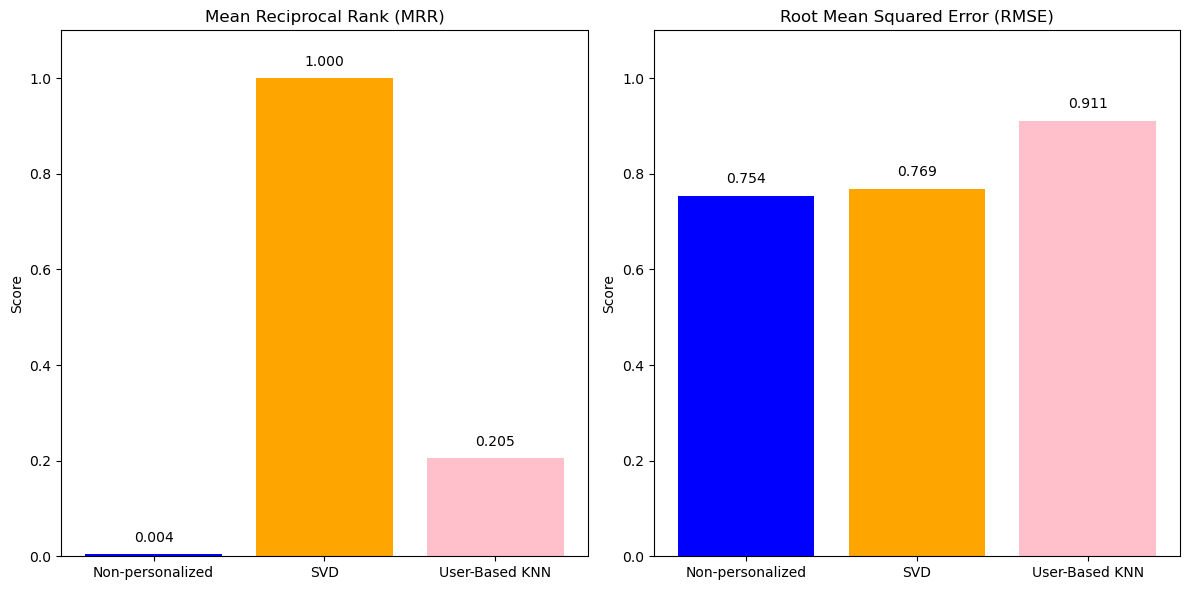

In [54]:
import matplotlib.pyplot as plt

methods = ['Non-personalized', 'SVD', 'User-Based KNN']
mrr_scores = [non_p_mrr,svd_mrr, user_based_mrr]
rmse_scores = [non_p_rmse,svd_rmse, user_based_rmse]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
bars = plt.bar(methods, mrr_scores, color=['blue', 'orange', 'pink'])
plt.title('Mean Reciprocal Rank (MRR)')
plt.ylabel('Score')
plt.ylim(0, 1.1)

for bar, score in zip(bars, mrr_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, f'{score:.3f}', ha='center', va='bottom')

plt.subplot(1, 2, 2)
bars = plt.bar(methods, rmse_scores, color=['blue', 'orange', 'pink'])
plt.title('Root Mean Squared Error (RMSE)')
plt.ylabel('Score')
plt.ylim(0, 1.1)


for bar, score in zip(bars, rmse_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, f'{score:.3f}', ha='center', va='bottom')

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

plt.tight_layout()
plt.show()

In [113]:
print(methods)
print('---MRR---')
print(mrr_scores)
print('---RMSE---')
print(rmse_scores)

['Non-personalized', 'SVD', 'User-Based KNN']
---MRR---
[0.004327961570412083, 1.0, 0.20525544029551035]
---RMSE---
[0.753621009341959, 0.7685941795064926, 0.910918728894574]


Disclaimer: I did not manage to implement the MRR and RMSE for the content based recommender.

##### Comments on the results:

As expected the MRR of the non-personalized recommender is ridiculous, and it is an indicative of the nature of the recommender as it does not take into account the users preferences or behaviour does not result in relevant recommendations. Although the RSME is a bit high, for being a non-personalized model, it indicates that the predictions of the ratings are not that far off.

The User-Based recommender shows improvement in the MRR compared with the Non-personalized recsys, but still far off from an optimal one. In terms of RMSE, this one is even higher, which is quite surprising, but it also seems to indicate what the user-user approach may not capture all relevant features in the data, and therefore fails to predict the user's ratings.

Lastly, the results for the SVD for RMSE are quite close to the non-personalized, which seems surprising given how different are both approaches, and again the RMSE is not really that far off the actual prediction.